In [3]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib


In [62]:
import importlib
importlib.reload(AE_Stats)

<module 'AE_Stats' from '/uscms_data/d3/nswood/Notebooks/ECON_AE_Development/AE_Stats.py'>

In [5]:
class CAE(nn.Module):
    """A Naive implementation of the DAE to be trained without RBMs"""

    def __init__(self, enc_layers,dec_layers):
        """Initialize the DAE

        Parameters
        ----------
        layers: list[int]
            the number of dimensions in each layer of the DAE

        """
        super(CAE, self).__init__()

        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.init_conv = nn.Conv1d(1, 3, 3, stride=3)
        
        encoders = []
        decoders = []

        prev_layer = enc_layers[0]
        for layer in enc_layers[1:]:
            encoders.append(
                nn.Linear(in_features=prev_layer, out_features=layer))
            encoders.append(
                nn.ReLU())
            prev_layer = layer
            
        prev_layer = dec_layers[0]
        for layer in dec_layers[1:]:
            decoders.append(
                nn.Linear(in_features=layer, out_features=prev_layer))
            decoders.append(
                nn.ReLU())

            prev_layer = layer
        
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))
            
    def forward(self, x):
        x_conv = self.init_conv(torch.unsqueeze(x,dim=1))
        
        x_cur = torch.hstack([x,torch.flatten(x_conv,start_dim = 1)])
        x_encoded = self.encode(x_cur)
        x_reconstructed = self.decode(x_encoded)
        return x_reconstructed

    def encode(self, x):
        
        for i, enc in enumerate(self.encoders):
            if i == len(self.encoders) - 1:
                x = enc(x)
            else:
                x = enc(x)
        return x
    
    def decode(self, x):
       
        for dec in self.decoders:
            x = dec(x)
        return x

In [329]:
class CAE_p(nn.Module):
    """A Naive implementation of the DAE to be trained without RBMs"""

    def __init__(self, enc_layers,dec_layers):
        """Initialize the DAE

        Parameters
        ----------
        layers: list[int]
            the number of dimensions in each layer of the DAE

        """
        super(CAE_p, self).__init__()

        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.init_conv = nn.Conv1d(1, 10, 3, stride=1)
        
        encoders = []
        decoders = []

        prev_layer = enc_layers[0]
        for layer in enc_layers[1:]:
            encoders.append(
                nn.Linear(in_features=prev_layer, out_features=layer))
            encoders.append(
                nn.ReLU())
            prev_layer = layer
            
        prev_layer = dec_layers[0]
        for layer in dec_layers[1:]:
            decoders.append(
                nn.Linear(in_features=layer, out_features=prev_layer))
            decoders.append(
                nn.ReLU())

            prev_layer = layer
        
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))
            
    def forward(self, x):
        x_conv = self.init_conv(torch.unsqueeze(x,dim=1))
        
        x_cur = torch.hstack([x,torch.flatten(x_conv,start_dim = 1)])
        x_encoded = self.encode(x_cur)
        x_reconstructed = self.decode(x_encoded)
        return x_reconstructed

    def encode(self, x):
        
        for i, enc in enumerate(self.encoders):
            if i == len(self.encoders) - 1:
                x = enc(x)
            else:
                x = enc(x)
        return x
    
    def decode(self, x):
       
        for dec in self.decoders:
            x = dec(x)
        return x

In [8]:
n = 80

arr = torch.load('data/TTBAR/ttbar_1_greater_0_sim')
if n > 0:
    for i in range(n):
        arr = torch.vstack([arr,torch.load(f'data/TTBAR/ttbar_{int(n+2)}_greater_0_sim')])



In [9]:
tarr =arr[0:30000].float()

In [10]:
dt_1 = []
dt_2 = []
dt_3 = []

for a in arr:
    
    if a[-4].item() ==0.: 
        dt_1.append(a)
    elif a[-4].item() ==1.0: 
        dt_2.append(a)
    else:
        dt_3.append(a)
    
dt_1 = torch.vstack(dt_1).float()
dt_2 = torch.vstack(dt_2).float()   
dt_3 = torch.vstack(dt_3).float()   

In [32]:
mean_dt_1 = torch.mean(dt_1[:,0:48])
std_dt_1 = torch.std(dt_1[:,0:48])

In [12]:
dt = torch.tensor((dt_1[:,0:48]-mean)/std,dtype = torch.float)


/tmp/ipykernel_195929/2730005539.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt = torch.tensor((dt_1[:,0:48]-mean)/std,dtype = torch.float)


In [287]:
dt_sim = torch.hstack([dt[:,0:48],torch.unsqueeze(dt[:,-5],dim=1)])

In [19]:
size_train =150000
size_test = 3000
train_loc = dt[0:size_train]
test_loc = dt[-size_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=200,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=200,
    shuffle=False
)

train = dt[0:size_train]
test = dt[-size_test:]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=200,
    shuffle=False
)

test_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=200,
    shuffle=False
)

In [25]:
def AE_MSE(data,pred):
    return torch.mean(torch.sum((data-pred)**2,dim=1))

def AE_MAE(data,pred):
    return torch.mean(torch.sum(torch.abs(data-pred),dim=1))

def weighted_AE_MSE(data, pred):
    return torch.mean(torch.sum((data[:,0:48])**2,dim=1)*torch.sum((data-pred)**2,dim=1))

def dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

def log_dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(torch.log((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))


def std_error(data,pred):
    return torch.mean(torch.sum(torch.abs(torch.subtract(data,pred)),dim=1))
def calcQ_Error(data,pred, mean,std):
    return torch.mean(torch.sum(torch.abs(pred-pred),dim=1))*std+mean
    
def new_loss(data,pred,epoch,cut = 10):
    #Reconstruction
    mse = AE_MSE(data,pred)
    if epoch < cut:
        return mse + std_error(data,pred) + torch.log(calcQ_Error(data,pred,mean,std))
    else:
        #Energy Conservation
        sum_dt, sum_pred = torch.sum(data, dim=1), torch.sum(pred,dim=1)
        sum_error = torch.sum(torch.norm(sum_dt-sum_pred))
        

        return  mse + std_error(data,pred)+ torch.log(calcQ_Error(data,pred,mean,std))+ 0.1*sum_error*np.min([(epoch-cut)/cut,1])

In [26]:
num_epochs = 100
lr = 0.00045
loss = new_loss

MSE 8.733744621276855
Median 5.342426776885986
Standard Devitaion 15.424670219421387
Average std error 11.810051918029785
Average % Error of Energy Reconstruction 15.076497077941895


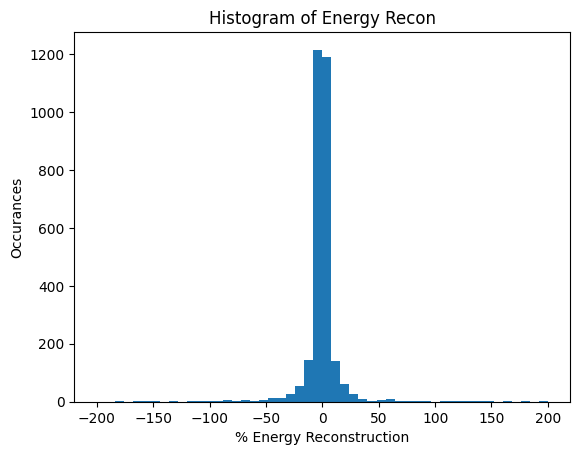

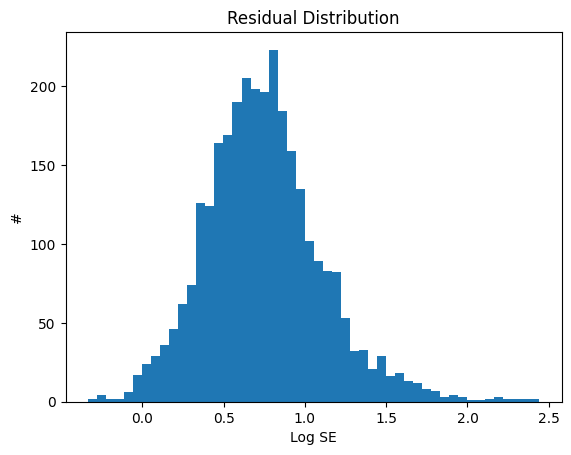

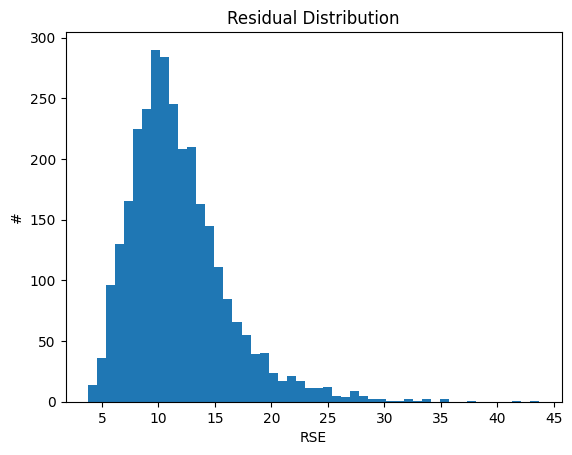

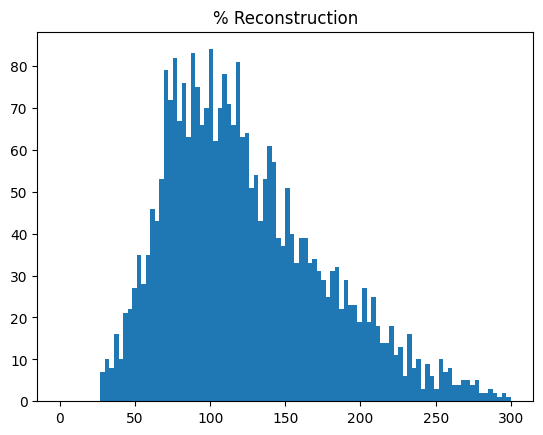

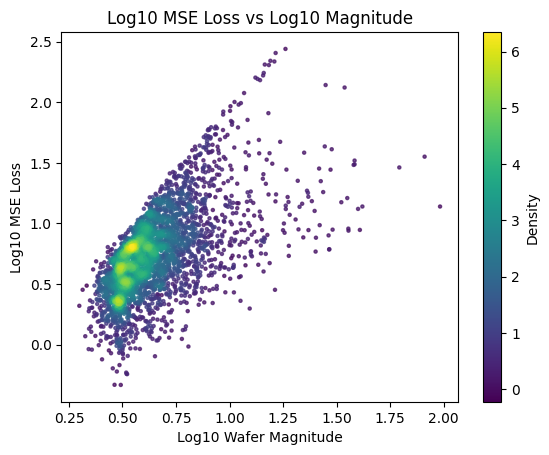

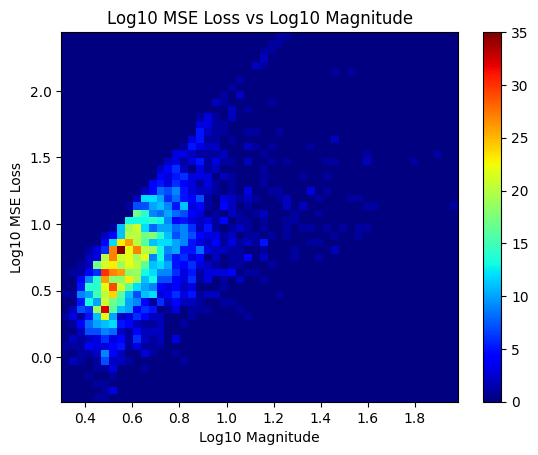

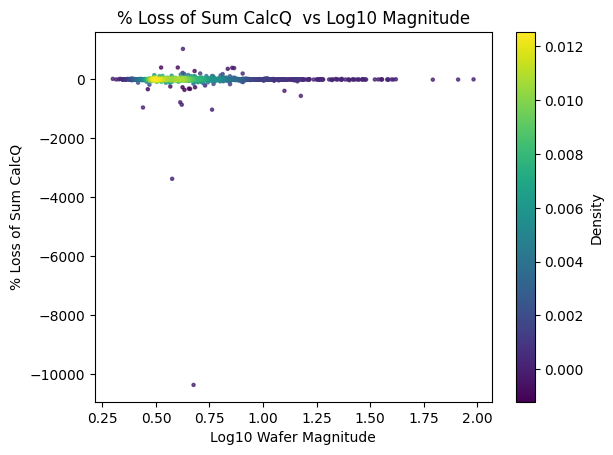

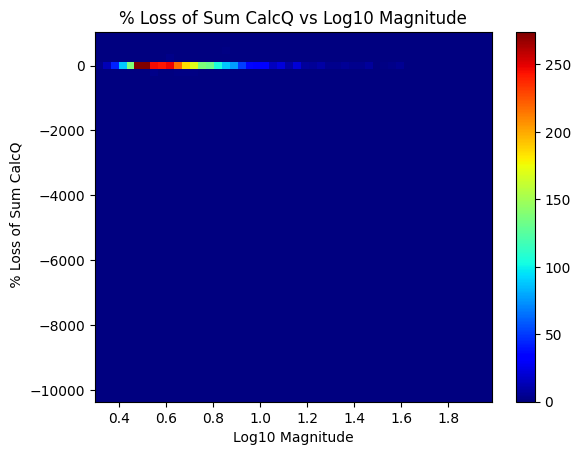

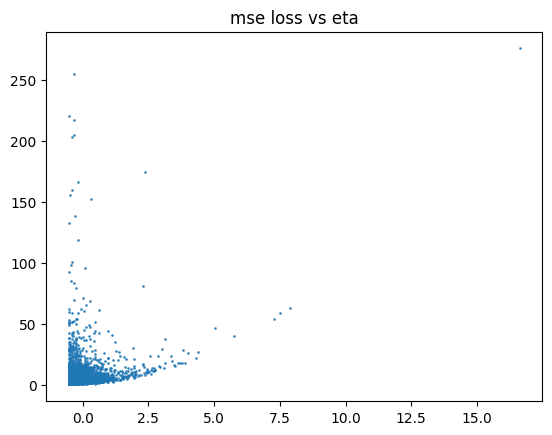

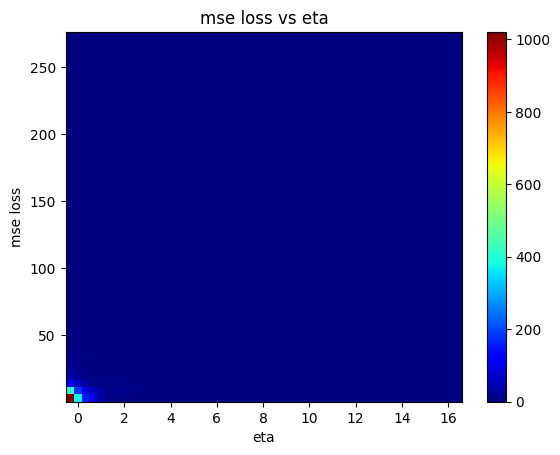

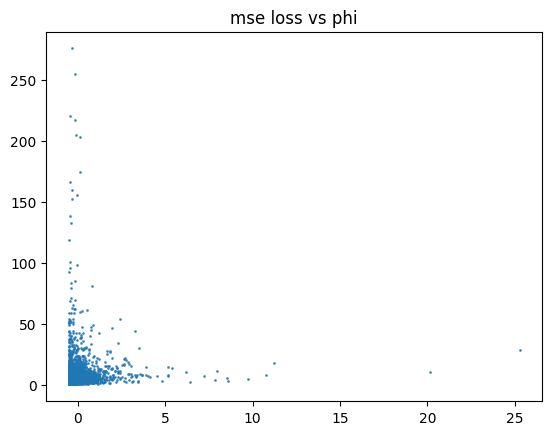

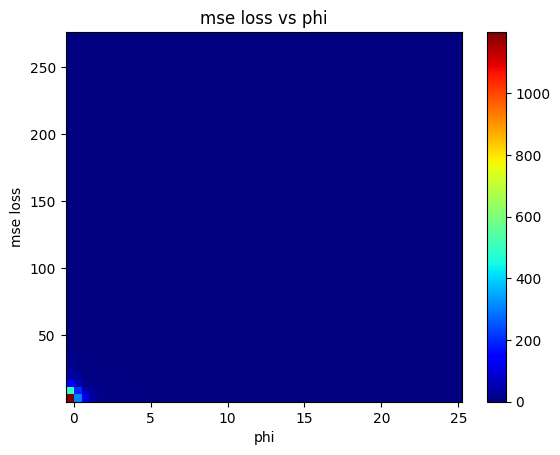

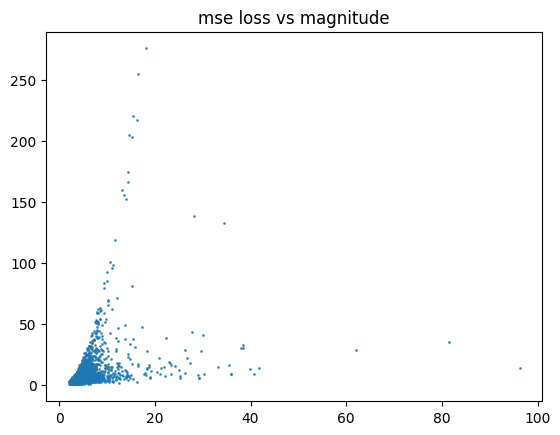

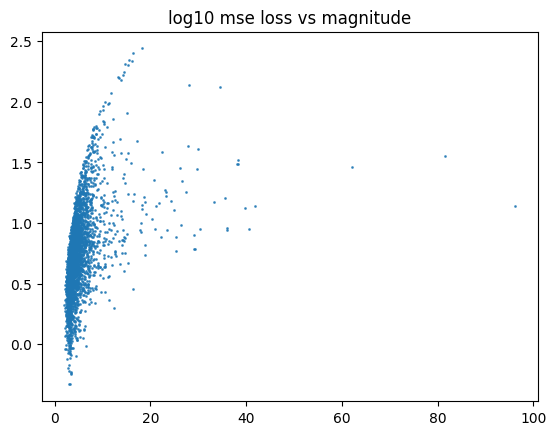

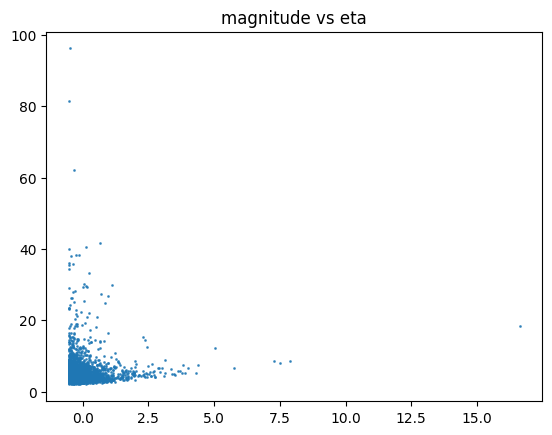

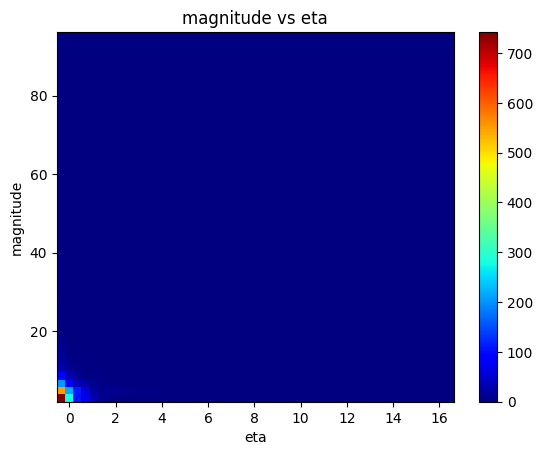

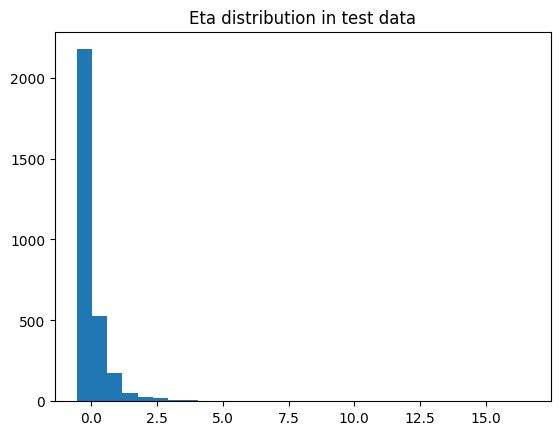

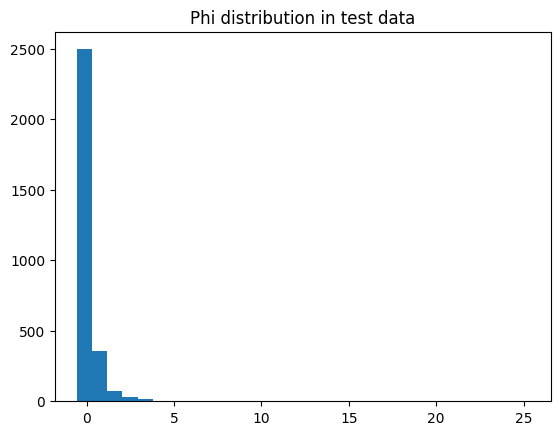

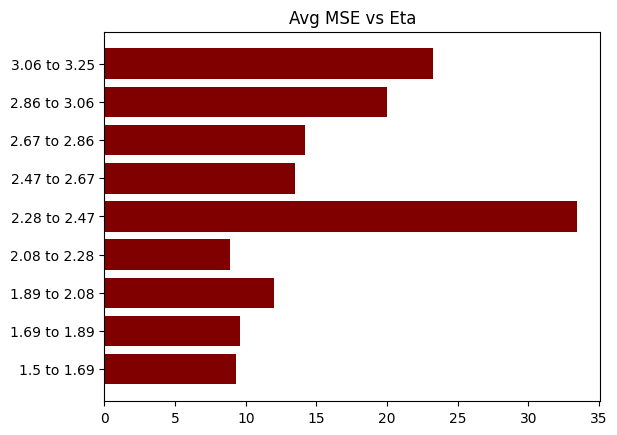

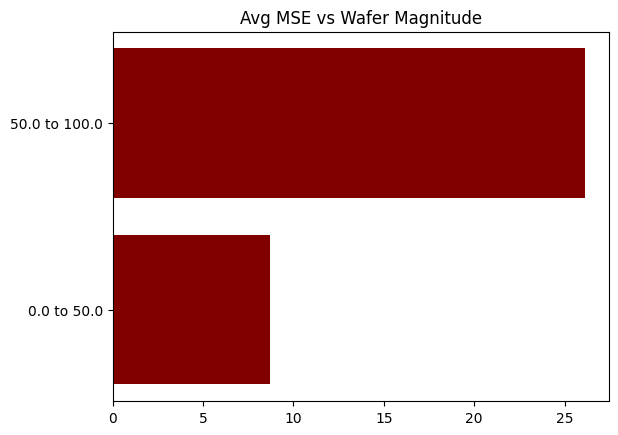

tensor([[ 0.1429,  0.6065,  4.4236,  7.0461, 14.6079],
        [ 0.8190, -0.3400,  3.2149,  5.3357, 12.5769],
        [-0.4559, -0.4172,  3.7843,  6.1263, 11.3611],
        ...,
        [-0.1468, -0.3979,  3.5652,  1.7033,  6.7504],
        [-0.5331, -0.4752,  4.1339,  5.6914, 10.6263],
        [-0.3013,  0.2009,  3.0976,  1.1290,  4.5505]], grad_fn=<CatBackward0>)

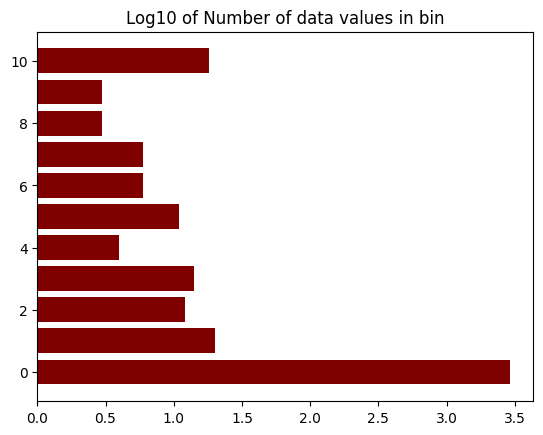

In [29]:
##### fine-tune autoencoder
#batch 500

# model_1 =  CAE([96,50,16],[48,50,16])
test = dt[-size_test:]
lr = 0.0045
optimizer = optim.Adam(model_1.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    break
    losses = []
    
    for i, data_list in enumerate(train_d1_flat):
        model_1.train()
        data = data_list[0]
        v_pred = model_1(data)
        
        batch_loss = loss(data[:,0:48], v_pred,epoch) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    model_1.eval()
    test_pred = model_1(data_test)
    batch_test = loss(data_test[:,0:48], test_pred,epoch)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
model_1.eval()
AE_Stats.gen_all_stats(model_1(test[-size_test:,0:48]),test[-size_test:,0:48],test[-size_test:])


In [64]:
def std_error(data,pred):
    return torch.mean(torch.sum(torch.abs(torch.subtract(data,pred)),dim=1))

std_error(model_1(test[-size_test:,0:48]),test[-size_test:,0:48])

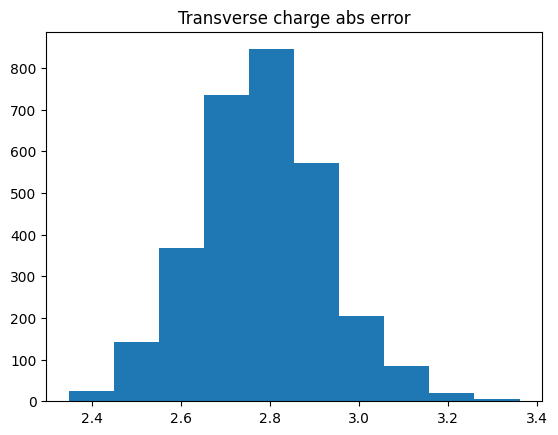

In [30]:
plt.title('Transverse charge abs error')
plt.hist(np.log10((torch.sum(torch.abs(model_1(test[-size_test:,0:48])-test[-size_test:,0:48]),dim=1)*std+mean).detach().numpy()))
plt.show()

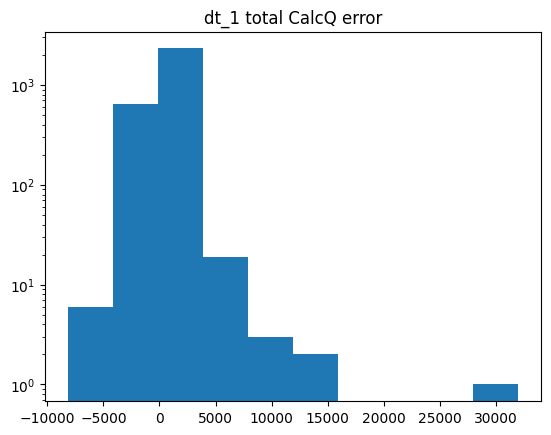

In [33]:
plt.title('dt_1 total CalcQ error')
plt.hist((torch.sum(dt_1[-size_test:,0:48]*std_dt_1+mean_dt_1,dim=1)-torch.sum(model_1(dt_1[-size_test:,0:48])*std_dt_1+mean_dt_1,dim=1)).detach().numpy(),log = True)
plt.show()

Epoch 0, lr 0.0045
Epoch 0: Train 88.31307203292846, Test 4885.923828125
Epoch 1, lr 0.0045
Epoch 1: Train 65.59191232681275, Test 3084.461181640625
Epoch 2, lr 0.0045
Epoch 2: Train 59.60136965751648, Test 2543.173095703125
Epoch 3, lr 0.0045
Epoch 3: Train 57.3638049030304, Test 1510.0452880859375
Epoch 4, lr 0.0045
Epoch 4: Train 55.800568346977236, Test 1627.57470703125
Epoch 5, lr 0.0045
Epoch 5: Train 55.889056725502016, Test 2357.409912109375
Epoch 6, lr 0.0045
Epoch 6: Train 53.87735113620758, Test 2275.114501953125
Epoch 7, lr 0.0045
Epoch 7: Train 53.469676885604855, Test 2120.630615234375
Epoch 8, lr 0.0045
Epoch 8: Train 53.658743934631346, Test 1247.8048095703125
Epoch 9, lr 0.0045
Epoch 9: Train 52.87737650871277, Test 1468.736083984375
Epoch 10, lr 0.0045
Epoch 10: Train 54.079378299713134, Test 3148.343017578125
Epoch 11, lr 0.0045
Epoch 11: Train 52.82439353942871, Test 1584.6868896484375
Epoch 12, lr 0.0045
Epoch 12: Train 52.5310152053833, Test 2285.128662109375
Epoc

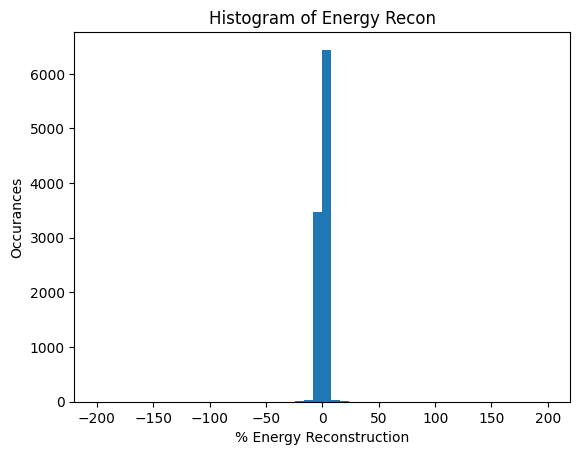

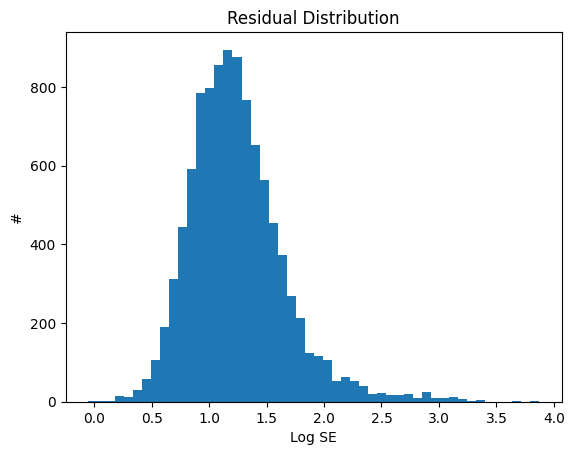

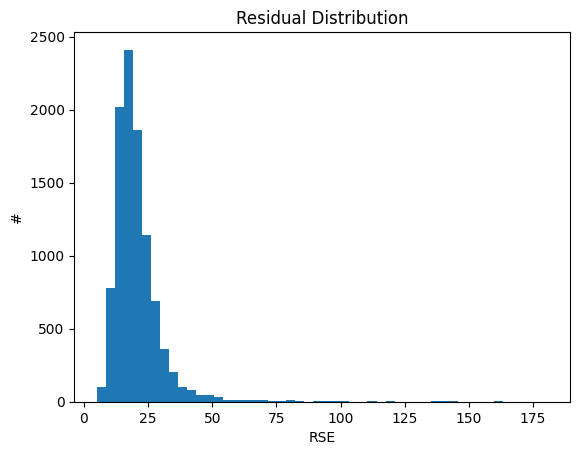

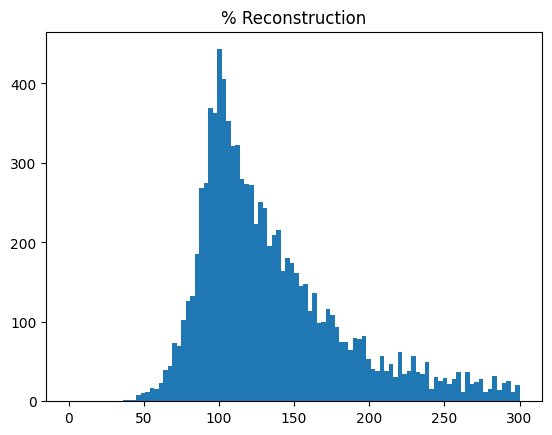

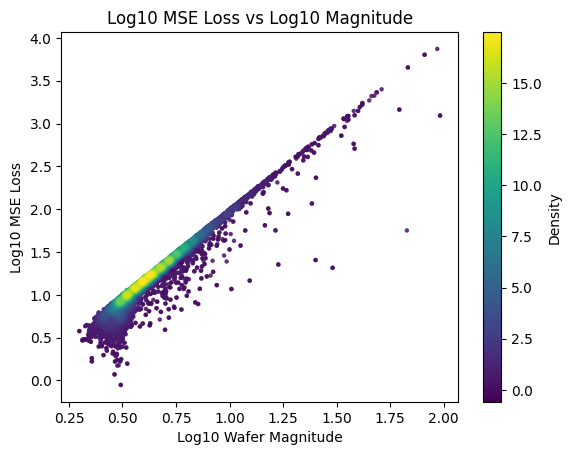

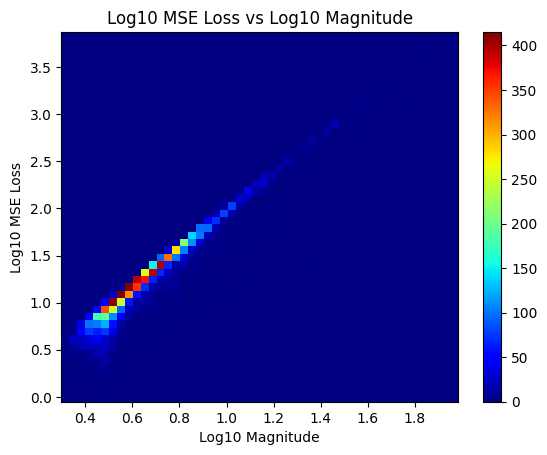

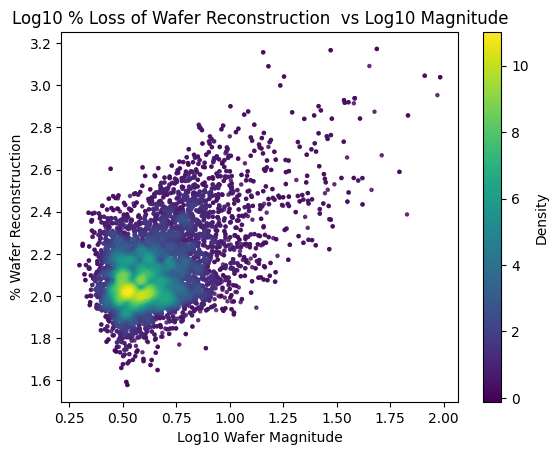

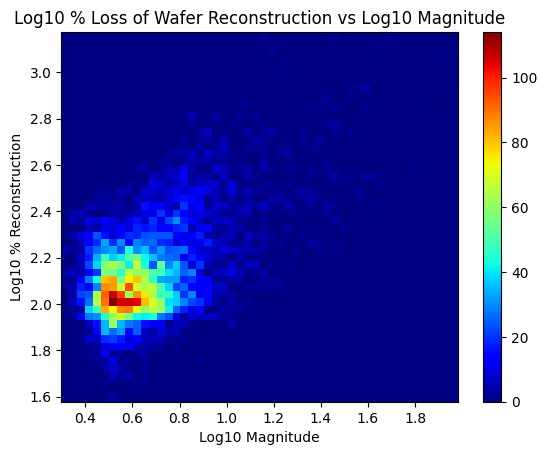

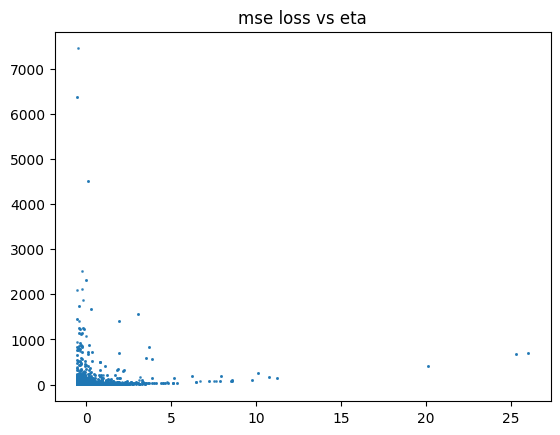

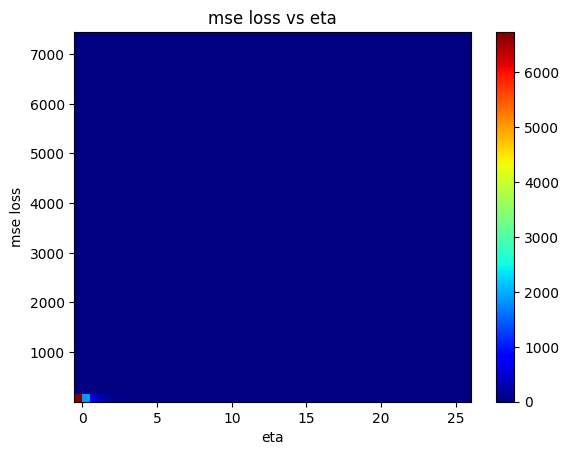

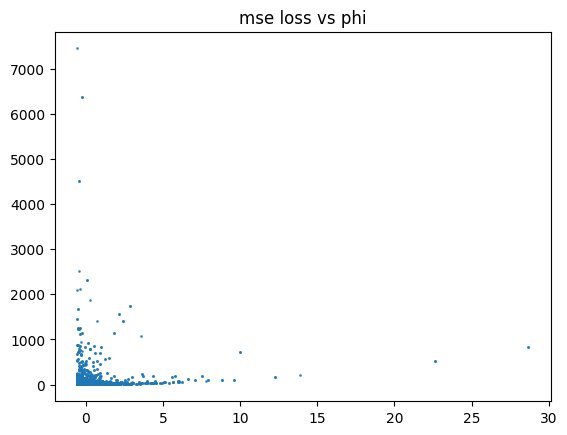

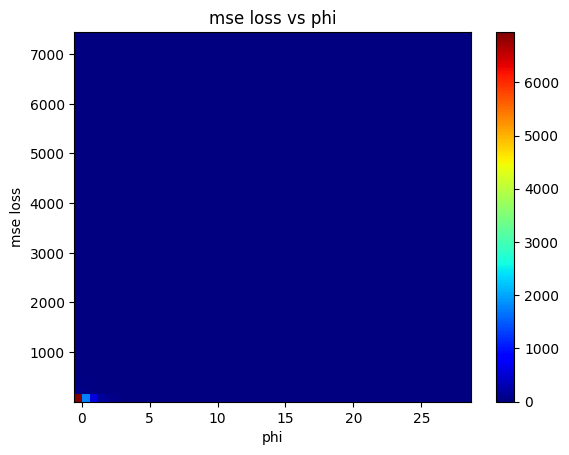

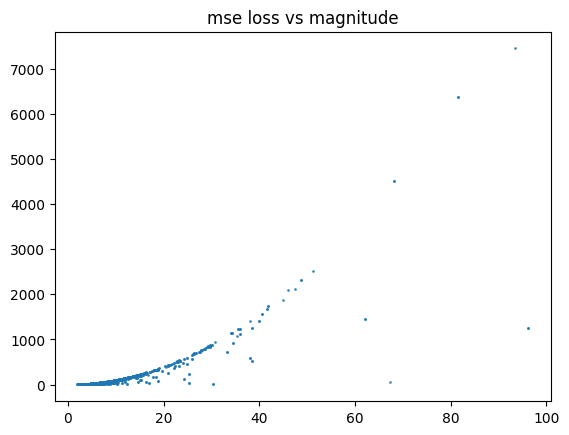

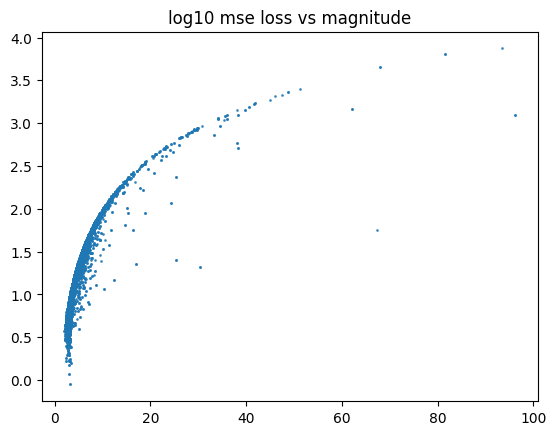

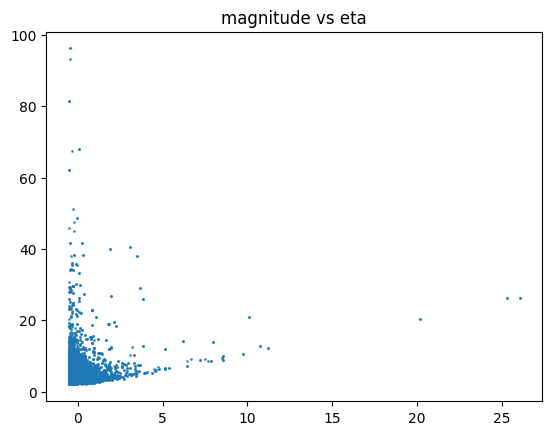

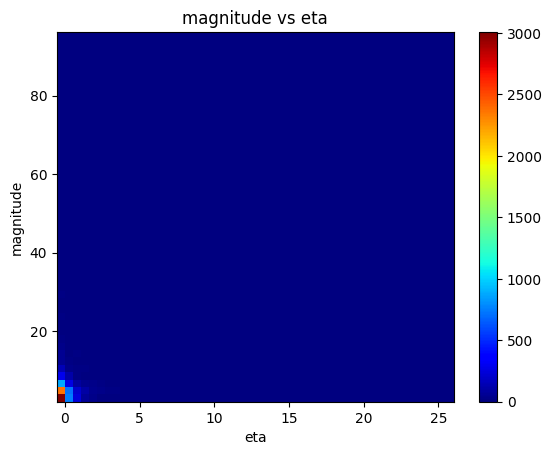

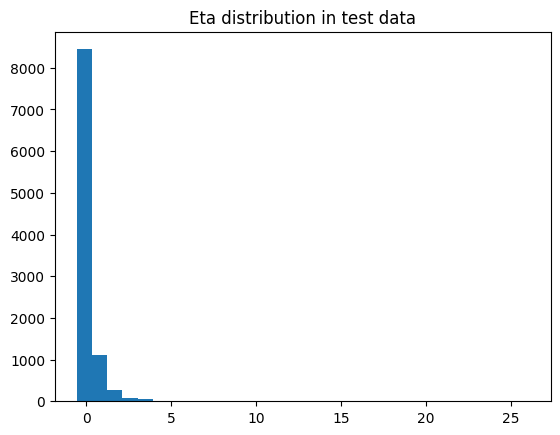

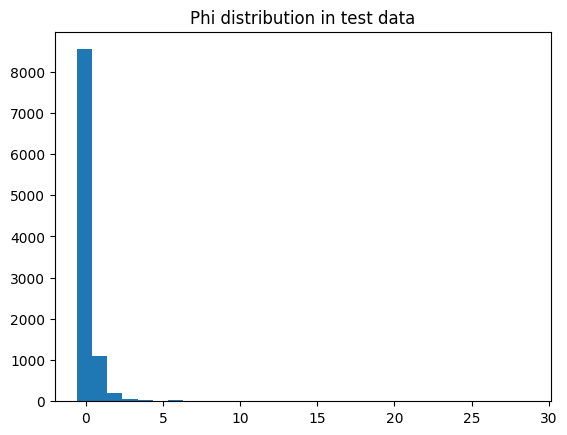

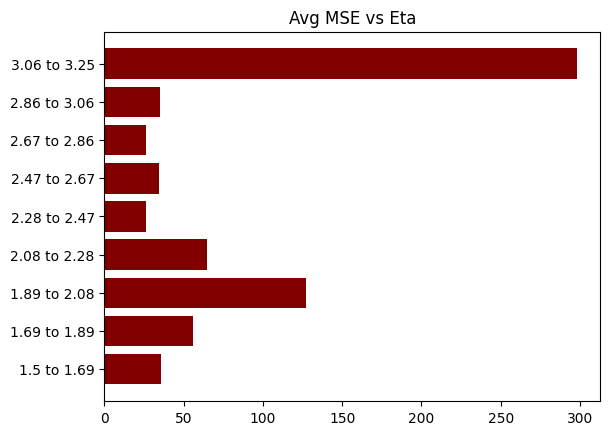

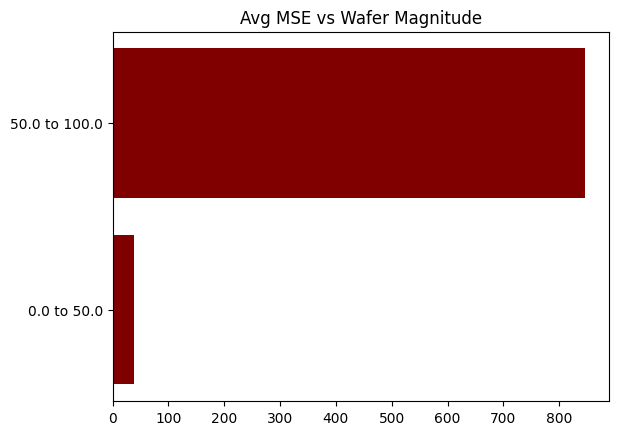

tensor([[-0.2048, -0.2627,  2.8719,  3.7678,  9.0361],
        [-0.2434, -0.5331,  6.0353, 34.6708, 17.1792],
        [-0.4366,  1.4757,  4.8630, 22.4372, 21.5206],
        ...,
        [-0.3979, -0.4752,  3.5652,  8.1257, 12.5577],
        [-0.4752, -0.5331,  4.1339, 15.1701, 18.6173],
        [ 0.2009,  0.3747,  3.0976,  4.0367, 10.2228]], grad_fn=<CatBackward0>)

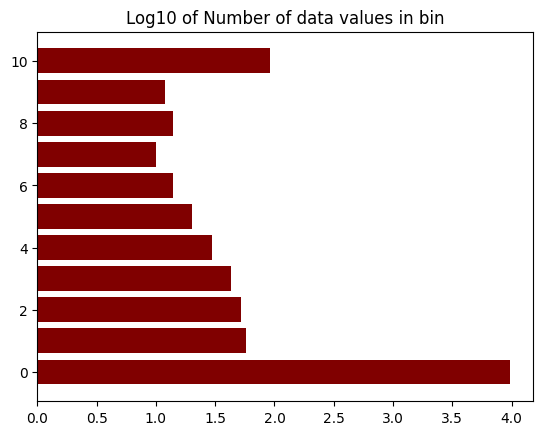

In [344]:
##### fine-tune autoencoder
#batch 500
loss = new_loss
model_2 =  CAE_p([519,16],[48,100,16])
lr = 0.0045
test = dt_sim[-size_test:]
optimizer = optim.Adam(model_2.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_d1_flat):
        model_2.train()
        data = data_list[0]
        v_pred = model_2(data)
        
        batch_loss = loss(data[:,0:48], v_pred) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    scheduler.step(batch_loss)
    data_test = test
    model_2.eval()
    test_pred = model_2(data_test)
    batch_test = loss(data_test[:,0:48], test_pred)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
model_2.eval()
AE_Stats.gen_all_stats(model_2(test[-size_test:,0:49]),test[-size_test:,0:48],test[-size_test:])
